In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report

Распарсим данные и немного посмотрим на них, после первого запуска мы видем уже немного смещенные мо гамме данные, это из-за нормализации

Ошибка в файле 61_1_20170109142408075.jpg: not enough values to unpack (expected 4, got 3)
Ошибка в файле 61_3_20170109150557335.jpg: not enough values to unpack (expected 4, got 3)
                        filename  age  gender
0  100_1_0_20170110183726390.jpg  100       1
1  100_1_2_20170105174847679.jpg  100       1
2  100_1_2_20170110182836729.jpg  100       1
3  101_1_2_20170105174739309.jpg  101       1
4   10_0_0_20161220222308131.jpg   10       0


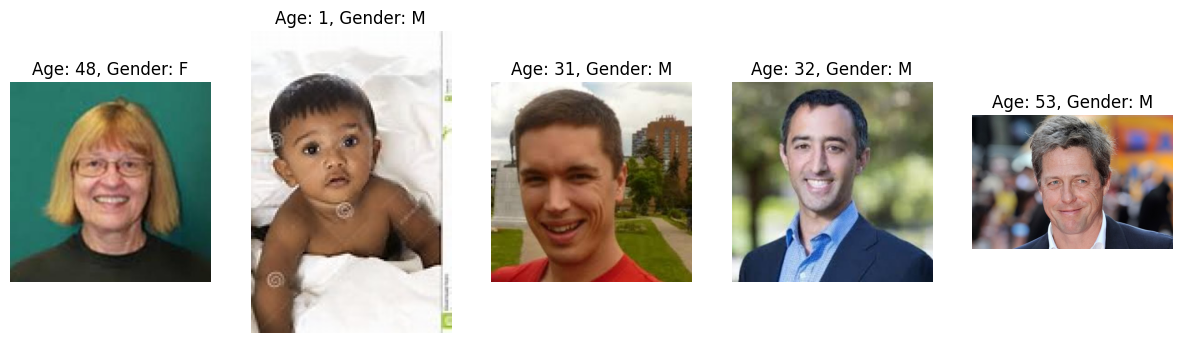

In [2]:
image_dir = "part1"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

def parse_filename(filename):
    try:
        age, gender, race, _ = filename.split("_", 3)
        return {
            "filename": filename,
            "age": int(age),
            "gender": int(gender),
        }
    except Exception as e:
        print(f"Ошибка в файле {filename}: {e}")
        return None

records = [parse_filename(f) for f in image_files]
records = [r for r in records if r is not None]
df = pd.DataFrame(records)

def show_samples(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        sample = df.sample(1).iloc[0]
        img_path = os.path.join(image_dir, sample["filename"])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Age: {sample['age']}, Gender: {'M' if sample['gender'] == 0 else 'F'}")
    plt.show()

print(df.head())
show_samples(df)

всего лишь в 2 файлах какая-то ошибка в имени что  не критично, теперь переобразуем возраст в категории

In [3]:
def categorize_age(age):
    if age <= 12:
        return "child"
    elif age <= 19:
        return "teen"
    elif age <= 35:
        return "young_adult"
    elif age <= 55:
        return "adult"
    elif age <= 75:
        return "senior"
    else:
        return "elderly"

df["age_category"] = df["age"].apply(categorize_age)
df["gender_label"] = df["gender"].apply(lambda g: "male" if g == 0 else "female")
df["multilabel"] = df.apply(lambda row: [row["age_category"], row["gender_label"]], axis=1)
print(df[["filename", "age", "age_category", "gender", "gender_label", "multilabel"]].head())


                        filename  age age_category  gender gender_label  \
0  100_1_0_20170110183726390.jpg  100      elderly       1       female   
1  100_1_2_20170105174847679.jpg  100      elderly       1       female   
2  100_1_2_20170110182836729.jpg  100      elderly       1       female   
3  101_1_2_20170105174739309.jpg  101      elderly       1       female   
4   10_0_0_20161220222308131.jpg   10        child       0         male   

          multilabel  
0  [elderly, female]  
1  [elderly, female]  
2  [elderly, female]  
3  [elderly, female]  
4      [child, male]  


запишем это как датасет чтобы обучатся а такче преобразуем все варианты меток в числа

In [4]:
all_labels = sorted(set(label for sublist in df["multilabel"] for label in sublist))
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Метки:", label_to_idx)

def multilabel_to_tensor(labels):
    tensor = torch.zeros(len(label_to_idx), dtype=torch.float32)
    for label in labels:
        tensor[label_to_idx[label]] = 1.0
    return tensor

df["label_tensor"] = df["multilabel"].apply(multilabel_to_tensor)

class FaceDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = row["label_tensor"]
        return image, labels

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = FaceDataset(df, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(dataloader))
print("Размер изображений:", images.shape)
print("Размер меток:", labels.shape)

Метки: {'adult': 0, 'child': 1, 'elderly': 2, 'female': 3, 'male': 4, 'senior': 5, 'teen': 6, 'young_adult': 7}
Размер изображений: torch.Size([32, 3, 128, 128])
Размер меток: torch.Size([32, 8])


Возьмем предобученную модель ResNet18 заменим у неё последний слой  и используем сигмоиду

In [5]:
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_labels)
        
        self.activation = nn.Sigmoid()

    def forward(self, x):
        logits = self.backbone(x)
        probs = self.activation(logits)
        return probs

In [6]:
num_labels = len(label_to_idx)
model = MultiLabelClassifier(num_labels=num_labels)
print(model)

C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiLabelClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


Напишем код для обучения модели

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
def train(model, dataloader, optimizer, criterion, device, epochs=2):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_loss = total_loss / (progress_bar.n + 1)

            progress_bar.set_postfix(loss=avg_loss)

        print(f"Epoch {epoch+1} complete. Avg loss: {avg_loss:.4f}")

In [10]:
train(model, dataloader, optimizer, criterion, device, epochs=2)

Epoch 1/2: 100%|██████████| 754/754 [07:08<00:00,  1.76it/s, loss=0.279]


Epoch 1 complete. Avg loss: 0.2789


Epoch 2/2: 100%|██████████| 754/754 [02:57<00:00,  4.25it/s, loss=0.185]

Epoch 2 complete. Avg loss: 0.1849


Посмотрим на результаты тестогого обучения

In [10]:
def visualize_predictions(model, dataset, device, num_samples=5, threshold=0.5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(18, 4))

    for i in range(num_samples):
        index = np.random.randint(len(dataset))
        image, true_labels = dataset[index]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
        
        predicted_mask = (output[0] >= threshold).cpu().numpy()

        true_labels_idx = [i for i, v in enumerate(true_labels) if v == 1]
        pred_labels_idx = [i for i, v in enumerate(predicted_mask) if v == 1]

        true_names = [idx_to_label[i] for i in true_labels_idx]
        pred_names = [idx_to_label[i] for i in pred_labels_idx]

        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].axis("off")
        axes[i].set_title(f"T: {true_names}\nP: {pred_names}", fontsize=10)

    plt.tight_layout()
    plt.show()


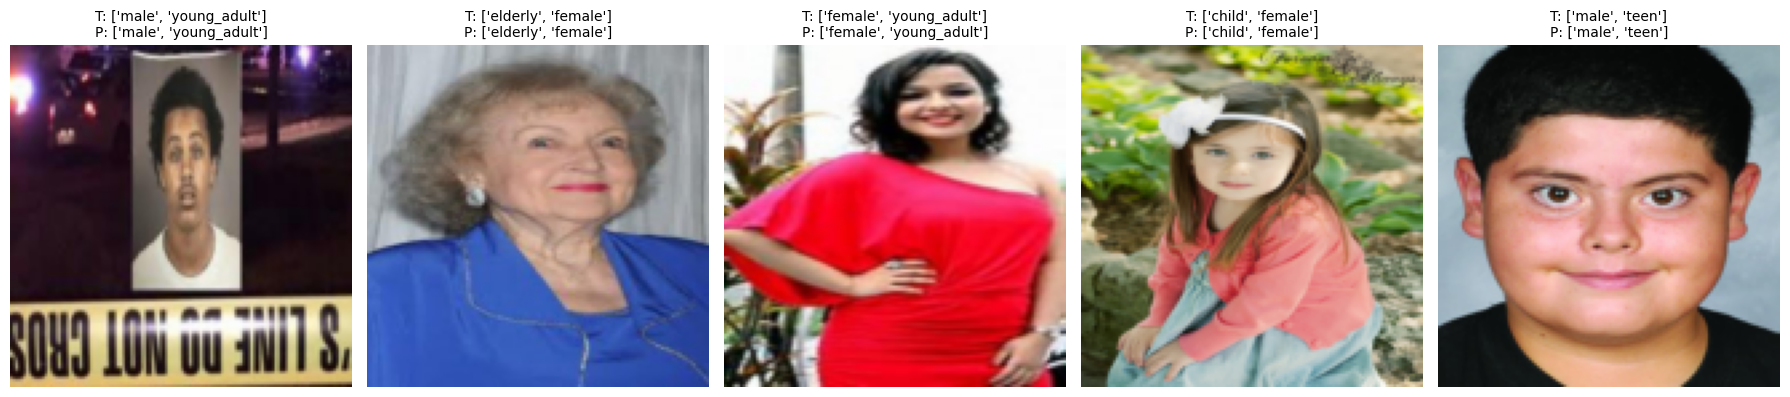

In [12]:
visualize_predictions(model, dataset, device, num_samples=5)


напишем код для проведения эксперементов

In [26]:
def run_experiment(learning_rate=1e-4, batch_size=32, image_size=128, epochs=5, model_name="model.pt"):
    print(f"\nЭксперимент: lr={learning_rate}, batch_size={batch_size}, image_size={image_size}")
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    
    dataset = FaceDataset(df, image_dir=image_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = MultiLabelClassifier(num_labels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train(model, dataloader, optimizer, criterion, device, epochs=epochs)

    torch.save(model.state_dict(), model_name)
    
    visualize_predictions(model, dataset, device, num_samples=5)

    return model

попробуем разные лернинг рейты и батч сайзы и проведем обучение


Эксперимент: lr=0.0001, batch_size=32, image_size=128


C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 317/317 [01:15<00:00,  4.18it/s, loss=0.31] 


Epoch 1 complete. Avg loss: 0.3097


Epoch 2/5: 100%|██████████| 317/317 [01:09<00:00,  4.57it/s, loss=0.185]


Epoch 2 complete. Avg loss: 0.1852


Epoch 3/5: 100%|██████████| 317/317 [01:09<00:00,  4.55it/s, loss=0.108]


Epoch 3 complete. Avg loss: 0.1084


Epoch 4/5: 100%|██████████| 317/317 [01:11<00:00,  4.45it/s, loss=0.0522]


Epoch 4 complete. Avg loss: 0.0522


Epoch 5/5: 100%|██████████| 317/317 [01:07<00:00,  4.70it/s, loss=0.0314]


Epoch 5 complete. Avg loss: 0.0314


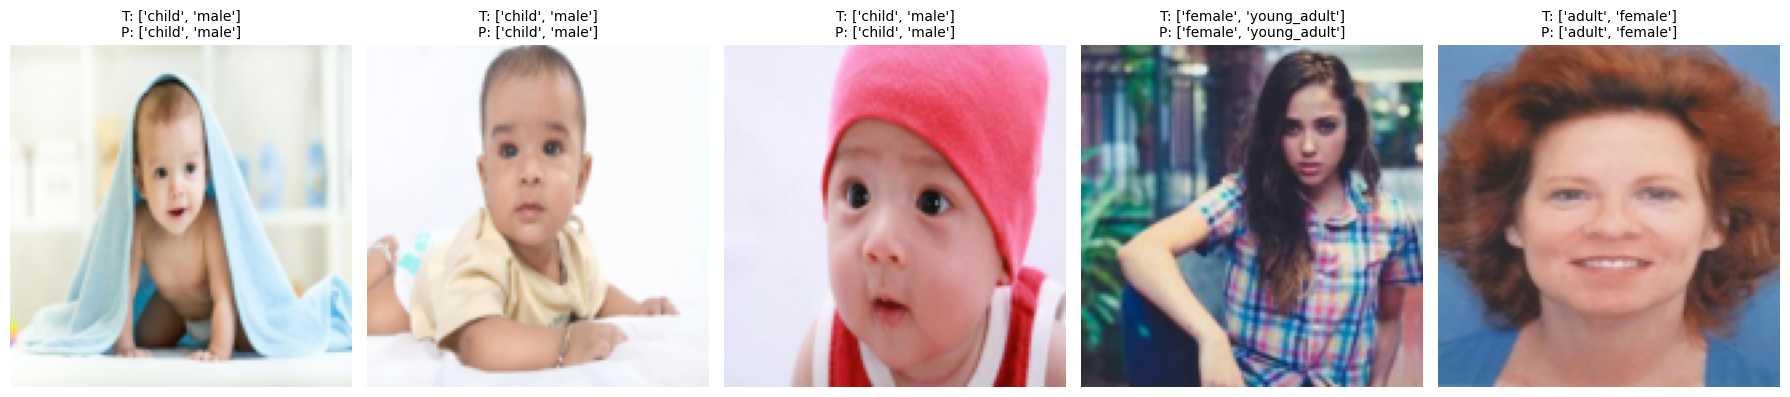


Эксперимент: lr=0.01, batch_size=32, image_size=128


Epoch 1/5: 100%|██████████| 317/317 [01:07<00:00,  4.71it/s, loss=0.51] 


Epoch 1 complete. Avg loss: 0.5104


Epoch 2/5: 100%|██████████| 317/317 [01:08<00:00,  4.63it/s, loss=0.457]


Epoch 2 complete. Avg loss: 0.4573


Epoch 3/5: 100%|██████████| 317/317 [01:06<00:00,  4.73it/s, loss=0.444]


Epoch 3 complete. Avg loss: 0.4443


Epoch 4/5: 100%|██████████| 317/317 [01:07<00:00,  4.69it/s, loss=0.435]


Epoch 4 complete. Avg loss: 0.4347


Epoch 5/5: 100%|██████████| 317/317 [01:08<00:00,  4.66it/s, loss=0.422]


Epoch 5 complete. Avg loss: 0.4216


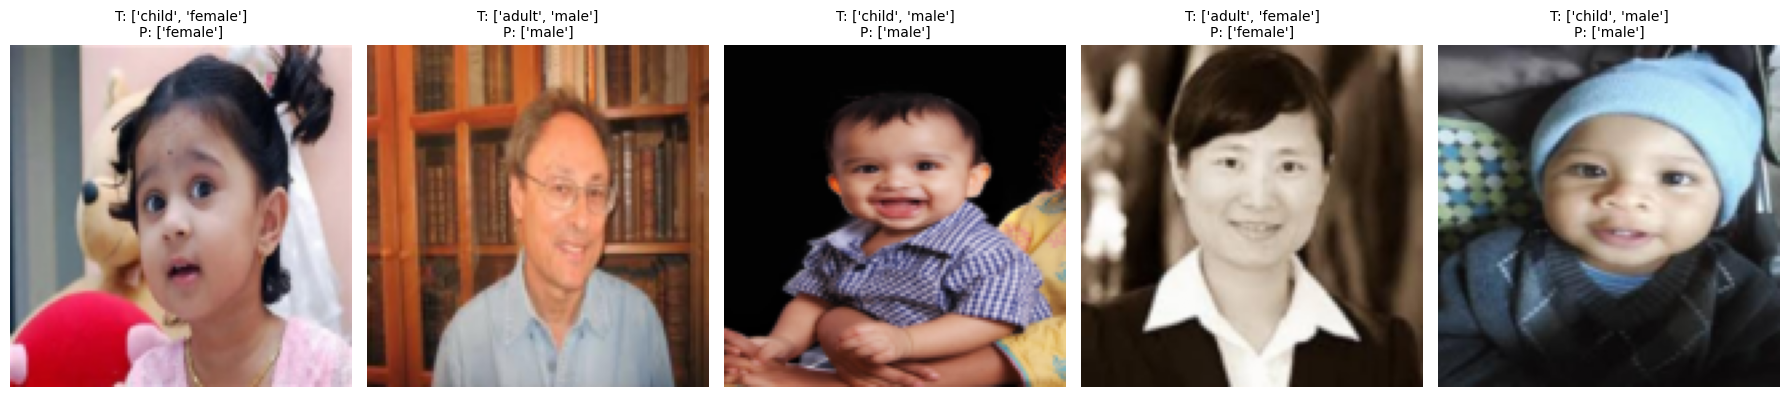


Эксперимент: lr=0.0001, batch_size=64, image_size=128


Epoch 1/5: 100%|██████████| 159/159 [01:03<00:00,  2.51it/s, loss=0.329]


Epoch 1 complete. Avg loss: 0.3292


Epoch 2/5: 100%|██████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.182]


Epoch 2 complete. Avg loss: 0.1821


Epoch 3/5: 100%|██████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.104]


Epoch 3 complete. Avg loss: 0.1036


Epoch 4/5: 100%|██████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.0496]


Epoch 4 complete. Avg loss: 0.0496


Epoch 5/5: 100%|██████████| 159/159 [01:08<00:00,  2.32it/s, loss=0.0247]


Epoch 5 complete. Avg loss: 0.0247


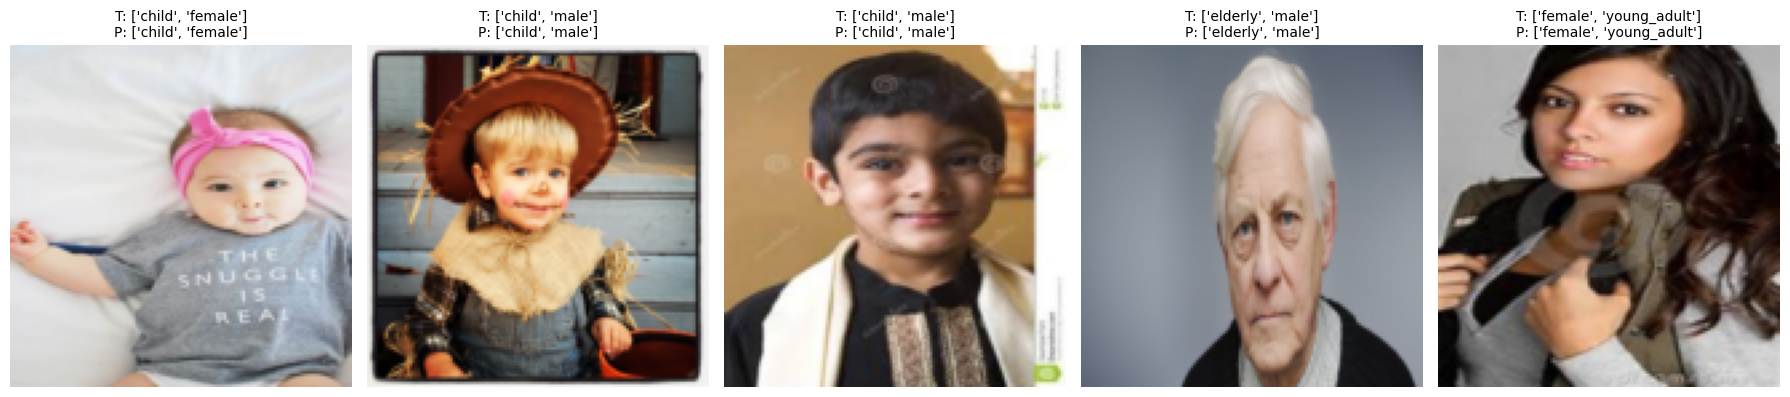

MultiLabelClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [27]:
run_experiment(learning_rate=1e-4, batch_size=32, image_size=128, model_name="model_lr1e-4.pt")

run_experiment(learning_rate=1e-2, batch_size=32, image_size=128, model_name="model_lr1e-2.pt")

run_experiment(learning_rate=1e-4, batch_size=64, image_size=128, model_name="model_bs64.pt")

попробуем протестировать наши модели на фото из 3 части которые они не видели

In [28]:
test_dir = "part3"
test_files = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

test_records = [parse_filename(f) for f in test_files]
test_records = [r for r in test_records if r is not None]
test_df = pd.DataFrame(test_records)
test_df["age_category"] = test_df["age"].apply(categorize_age)
test_df["gender_label"] = test_df["gender"].apply(lambda g: "male" if g == 0 else "female")
test_df["multilabel"] = test_df.apply(lambda row: [row["age_category"], row["gender_label"]], axis=1)
test_df["label_tensor"] = test_df["multilabel"].apply(multilabel_to_tensor)

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_dataset = FaceDataset(test_df, image_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs >= threshold).cpu().int()
            all_preds.append(preds)
            all_targets.append(labels.int())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    target_names = [idx_to_label[i] for i in range(len(idx_to_label))]
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

In [30]:
def load_model(model_path, num_labels):
    model = MultiLabelClassifier(num_labels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

посмотрим на метрики

In [31]:
model1 = load_model("model_lr1e-4.pt", num_labels)
evaluate_model(model1, test_loader, device)

model2 = load_model("model_lr1e-2.pt", num_labels)
evaluate_model(model2, test_loader, device)

model3 = load_model("model_bs64.pt", num_labels)
evaluate_model(model3, test_loader, device)


C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

       adult       0.51      0.48      0.50      1037
       child       0.15      0.41      0.22        27
     elderly       0.56      0.64      0.60       150
      female       0.87      0.89      0.88       996
        male       0.95      0.94      0.95      2254
      senior       0.46      0.59      0.52       431
        teen       0.16      0.13      0.14        47
 young_adult       0.81      0.53      0.64      1558

   micro avg       0.77      0.72      0.75      6500
   macro avg       0.56      0.58      0.55      6500
weighted avg       0.78      0.72      0.74      6500
 samples avg       0.78      0.72      0.74      6500



C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

       adult       0.30      0.00      0.01      1037
       child       0.01      0.19      0.02        27
     elderly       0.00      0.00      0.00       150
      female       0.51      0.76      0.61       996
        male       0.86      0.68      0.76      2254
      senior       0.62      0.01      0.02       431
        teen       0.00      0.00      0.00        47
 young_adult       0.86      0.09      0.17      1558

   micro avg       0.62      0.38      0.47      6500
   macro avg       0.40      0.22      0.20      6500
weighted avg       0.67      0.38      0.40      6500
 samples avg       0.67      0.38      0.47      6500



C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\MLlabs\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

       adult       0.59      0.40      0.47      1037
       child       0.17      0.41      0.24        27
     elderly       0.77      0.57      0.65       150
      female       0.83      0.91      0.87       996
        male       0.96      0.92      0.94      2254
      senior       0.54      0.58      0.56       431
        teen       0.08      0.09      0.08        47
 young_adult       0.76      0.70      0.73      1558

   micro avg       0.79      0.74      0.77      6500
   macro avg       0.59      0.57      0.57      6500
weighted avg       0.79      0.74      0.76      6500
 samples avg       0.80      0.74      0.76      6500



что можно по итогу сказать по моделям, хуже всего справилась модель с высоким лернин рейтом, по ощущениям она не сошлась и ушла в нестабильное обучение, по итогу некоторые классы вовсе не предсказывает

среденей вышла модель с бач сайзом 32, хорошо предсказывает пол, young_adult, elderly, adult, хуже child, teen потенциально из-за малого количества примеров

лучше всех справилась 3 модель с увеличенным бач сайзом, видимо это помогло, лучше предсказывает даже малочисленные классы, на которых не справлялась предыдущая модель